# Pearson's correlation coefficient

<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../../notebooks/08_colocalization/pixel_intensity_based_colocalization_pearsons.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/08_colocalization/pixel_intensity_based_colocalization_pearsons.ipynb" target="_blank">
        <img class="button-icon" src="../../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
# ]
# ///

## Description

In this section, we will explore how to implement in Python the **Pearson's Correlation Coefficient**, which is a common method for quantifying colocalization based on pixel intensities.

```{warning}
NOTE: this notebook aims to show how to practically implement these methods but does not aim to describe when to use which method. The images used have been selected to showcase the practical implementation of the methods.
```

### import libraries

In [ ]:
import matplotlib.pyplot as plt
import ndv
import numpy as np
import tifffile
from scipy.stats import pearsonr
from skimage.filters import threshold_otsu
from tqdm import tqdm

## Pearson's Correlation Coefficients

Pearson's correlation coefficients are a measure of colocalization that is based on the pixel intensities of two channels.

...

### open an image and visualize it with ndv

In [ ]:
# open the image
img_path = "../../_static/images/coloc/14na_z4.tif"
img = tifffile.imread(img_path)

In [ ]:
# visualize the image
ndv.imshow(img)

In [ ]:
viewer = ndv.imshow(img)

In [ ]:
viewer.widget().children[1].snapshot()

To compute Pearson's Correlation Coefficients, we need **two separate images** (channels).

What is the image shape? How do we split the channels?

In [5]:
# get image shape
print("Image shape:", img.shape)

Image shape: (2, 512, 512)


In [6]:
# split the image into channels
ch1 = img[0]
ch2 = img[1]

## Pearson's Correlation Coefficient
<!-- <div align="center"> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/pearsons.png" alt="Ilastik Logo" width="600"></div> -->
<div align="left"> <img src="../../_static/images/coloc/pearsons.png" alt="Ilastik Logo" width="600"></div>

In [ ]:
# plot scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(ch1.flatten(), ch2.flatten(), s=1, alpha=0.5)
plt.xlabel("Image 1 Intensity")
plt.ylabel("Image 2 Intensity")
plt.title("Scatter Plot of Pixel Intensities")
# set both axes to the same range based on the maximum value
max_intensity = max(ch1.max(), ch2.max())
plt.xlim(0, max_intensity)
plt.ylim(0, max_intensity)
plt.show()

In [ ]:
mean_ch1 = np.mean(ch1)
mean_ch2 = np.mean(ch2)

numerator = np.sum((ch1 - mean_ch1) * (ch2 - mean_ch2))
denominator = np.sqrt(np.sum((ch1 - mean_ch1) ** 2) * np.sum((ch2 - mean_ch2) ** 2))
prs = numerator / denominator
print(f"Pearson's correlation coefficient: {prs:.4f}")

pearson, p_value = pearsonr(ch1.flatten(), ch2.flatten())
print(
    f"Pearson's correlation coefficient (scipy): {pearson:.4f}, p-value: {p_value:.4f}"
)

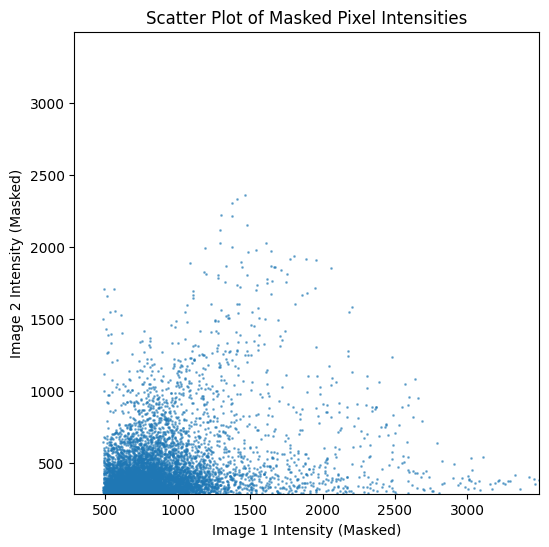

Pearson's correlation coefficient (masked): 0.2654
Pearson's correlation coefficient (masked, scipy): 0.2654, p-value: 0.0000


In [ ]:
# calculate pearsons on thresholded images
image_1_mask = ch1 > threshold_otsu(ch1)
image_2_mask = ch2 > threshold_otsu(ch2)

# get the overlap mask
overlap_mask = image_1_mask & image_2_mask

# extract intensity from channel 1 only at pixels where both channels overlap
image_1_masked = ch1[overlap_mask]
# extract intensity from channel 2 only at pixels where both channels overlap
image_2_masked = ch2[overlap_mask]

# plot scatter plot for masked images
plt.figure(figsize=(6, 6))
plt.scatter(image_1_masked.flatten(), image_2_masked.flatten(), s=1, alpha=0.5)
plt.xlabel("Image 1 Intensity (Masked)")
plt.ylabel("Image 2 Intensity (Masked)")
plt.title("Scatter Plot of Masked Pixel Intensities")
# set both axes to the same range based on the maximum value of the masked images
max_intensity_masked = max(image_1_masked.max(), image_2_masked.max())
min_intensity_masked = min(image_1_masked.min(), image_2_masked.min())
plt.xlim(min_intensity_masked, max_intensity_masked)
plt.ylim(min_intensity_masked, max_intensity_masked)
plt.show()

mean_ch1_masked = np.mean(image_1_masked)
mean_ch2_masked = np.mean(image_2_masked)

numerator_masked = np.sum(
    (image_1_masked - mean_ch1_masked) * (image_2_masked - mean_ch2_masked)
)
denominator_masked = np.sqrt(
    np.sum((image_1_masked - mean_ch1_masked) ** 2)
    * np.sum((image_2_masked - mean_ch2_masked) ** 2)
)
prs_masked = numerator_masked / denominator_masked
print(f"Pearson's correlation coefficient (masked): {prs_masked:.4f}")

# Verify with scipy's pearsonr on the same masked data
pearson_masked_scipy, p_value_masked = pearsonr(image_1_masked, image_2_masked)
print(
    f"Pearson's correlation coefficient (masked, scipy): {pearson_masked_scipy:.4f}, p-value: {p_value_masked:.4f}"
)

### Costes Pixel Randomization Test

The **Costes pixel randomization test** is a statistical method used to validate the significance of colocalization results, particularly for Pearson's correlation coefficients. This method involves **randomly shuffling the pixel intensities of one channel and recalculating the Pearson's correlation coefficient** to create a distribution of values under the null hypothesis of no colocalization.

Below you can find an implementation of this method in Python. This function returns the observed Pearson's correlation coefficient, a list of randomized correlation coefficients, and the p-value indicating the significance of the observed correlation.

A low `p-value` (e.g. 0.0001) means that none of the `n` random translations (by default 1000) produced a correlation coefficient as high as the observed one, indicating that the observed colocalization is statistically significant: the probability of getting the observed colocalization by random chance is < 0.0001 (less than 0.01%).

Let's run it on the two channels we have been working with.

In [41]:
def costes_pixel_randomization(
    channel_1: np.ndarray,
    channel_2: np.ndarray,
    n_iterations: int = 1000,
    seed: int = 3,
) -> tuple[float, list[float], float]:
    """
    Perform Costes pixel randomization test for colocalization significance.

    Parameters:
    -----------
    channel_1 : np.ndarray
        Reference channel (kept unchanged)
    channel_2 : np.ndarray
        Channel to be randomized
    n_iterations : int
        Number of randomization iterations (default: 1000)
    seed : int
        Random numpy seed for reproducibility (default: 3)

    Returns:
    --------
    Tuple containing:
        - float: Observed correlation coefficient
        - List[float]: Correlation coefficients from randomized iterations
        - float: P-value (fraction of random correlations >= observed)
    """
    # Set the numpy random seed for reproducibility
    np.random.seed(seed)

    # Calculate observed correlation
    observed_correlation, _ = pearsonr(channel_1.flatten(), channel_2.flatten())

    # Initialize list to store randomized correlations
    random_correlations = []

    # Store original shape for reshaping
    shape = channel_2.shape

    for _ in tqdm(range(n_iterations), desc="Costes pixel randomization"):
        # Flatten, shuffle, and reshape
        randomized_channel_2 = np.random.permutation(channel_2.flatten()).reshape(shape)

        # Calculate correlation with randomized channel
        random_corr, _ = pearsonr(channel_1.flatten(), randomized_channel_2.flatten())
        random_correlations.append(random_corr)

    # Calculate p-value: fraction of random correlations >= observed correlation
    p_value = (
        np.sum(np.array(random_correlations) >= observed_correlation) / n_iterations
    )

    return observed_correlation, random_correlations, p_value

We can now run the Costes pixel randomization test and print the pearson's correlation coefficient and the p-value from the test.

In [42]:
p, random_corrs, p_value = costes_pixel_randomization(ch1, ch2)
# p, random_corrs, p_value = costes_pixel_randomization(image_1_masked, image_2_masked)
print(f"Observed Pearson's correlation: {p:.4f}, p-value: {p_value:.4f}")

Costes pixel randomization: 100%|██████████| 1000/1000 [00:05<00:00, 177.98it/s]

Observed Pearson's correlation: 0.5383, p-value: 0.0000


**Bonus:**

We can also visualize the distribution of the randomized Pearson's correlation coefficients to better understand the significance of our observed correlation.

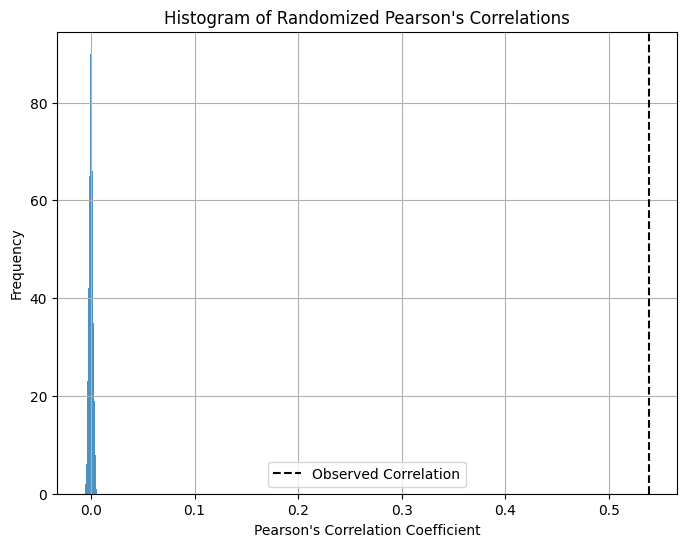

In [43]:
# plot histogram of random correlations
plt.figure(figsize=(8, 6))
plt.hist(random_corrs, bins=30, alpha=0.8)
plt.axvline(
    p, color="k", linestyle="dashed", linewidth=1.5, label="Observed Correlation"
)
plt.title("Histogram of Randomized Pearson's Correlations")
plt.xlabel("Pearson's Correlation Coefficient")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()